In [698]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [699]:
# Load duplicate and unique data (existing results)
data = pd.read_csv(f"..\\results\\working_results\\mT5\\duplicates\\duplicates_combined_all_levels.csv")
data_unique = pd.read_csv(f"..\\results\\working_results\\mT5\\unique\\unique_combined_all_levels.csv")

# Drop rows with NaN values in the 'Levenshtein distance (avg)' column
data = data.dropna(subset=['Levenshtein distance (avg)'])
data_unique = data_unique.dropna(subset=['Levenshtein distance (avg)'])

data_duplicate_unique = pd.concat([data, data_unique], ignore_index=False)

In [700]:
# Retrieve token distribution of data_duplicate_unique
duplicate_unique_token_lengths = data_duplicate_unique['Input sequence (ground truth)'].str.split().str.len()

# Calculate the target distribution (duplicate_unique data)
target_distribution = duplicate_unique_token_lengths.value_counts(normalize=True).sort_index()

In [701]:
# Load baseline datasets (3 newspapers)
data_baseline_volkskrant = pd.read_csv('..\\data\\baseline\\raw_baseline_volkskrant.csv')
data_baseline_nrc = pd.read_csv('..\\data\\baseline\\raw_baseline_nrc.csv')
data_baseline_ad = pd.read_csv('..\\data\\baseline\\raw_baseline_ad.csv')

In [702]:
# Add a column to indicate the source newspaper
data_baseline_volkskrant['title'] = 'volkskrant'
data_baseline_nrc['title'] = 'nrc'
data_baseline_ad['title'] = 'ad'

# Combine the baseline datasets
combined_baseline_data = pd.concat([data_baseline_volkskrant, data_baseline_nrc, data_baseline_ad], ignore_index=True)

In [703]:
# Shuffle combined baseline data
combined_baseline_data = combined_baseline_data.sample(frac=1, random_state=42).reset_index(drop=True)
combined_baseline_data

,text,text_count,link,paywall,title
0,Sietske van den Berg (34) betaalde 44 euro voo...,1,Sietske betaalde 44 euro voor ontspanning in d...,ja,ad
1,Uitvoeringsinstanties zoals de Belastingdienst...,1,https://www.ad.nl/politiek/rechtsstaat-langdur...,ja,ad
2,China plant een golf aan nieuwe ruimtemissies ...,1,Hoe vang je een planetoïde? China heeft groots...,ja,nrc
3,Het Nederlands Film Festival dreigt de volledi...,1,https://www.volkskrant.nl/films/nederlands-fil...,ja,volkskrant
4,Zelfs nu de rechter heeft geoordeeld dat hij z...,1,"Hij is als enige over op camping, maar Henk we...",ja,ad
...,...,...,...,...,...
295,Omdat grote banken nauwelijks met elkaar hoeve...,1,https://www.nrc.nl/nieuws/2024/05/28/spaarmark...,ja,nrc
296,Film- en serieliefhebbers zijn steeds meer gel...,1,https://www.volkskrant.nl/economie/streamingdi...,ja,volkskrant
297,Na de dood van de achttienjarige Ryan al Najja...,1,OM vordert mails aan De Telegraaf met vermeend...,ja,nrc
298,‘Wil je me even bellen?’ Het is donderdagochte...,1,https://www.ad.nl/binnenland/ten-onrechte-als-...,ja,ad


In [704]:
# Function to truncate sequences at sentence boundaries using stratified sampling
def truncate_sequences(data, target_distribution):
    truncated_sequences = []
    total_sequences = len(data)
    
    for length, weight in target_distribution.items():
        sample_size = max(int(weight * total_sequences), 1)
        sampled_sequences = data['text'].sample(n=sample_size, replace=True)
        
        for seq in sampled_sequences:
            tokens = seq.split()
            truncated_seq = []
            token_count = 0
            for token in tokens:
                truncated_seq.append(token)
                token_count += 1
                if token_count >= length and token[-1] in {'.', '!', '?'}:
                    break
            truncated_sequences.append(' '.join(truncated_seq))
    
    np.random.shuffle(truncated_sequences)
    return truncated_sequences[:total_sequences]

# Truncate combined baseline data sequences
combined_baseline_data['text'] = truncate_sequences(combined_baseline_data, target_distribution)

# Split the combined DataFrame back into three separate DataFrames based on the source newspaper
baseline_volkskrant_truncated = combined_baseline_data[combined_baseline_data['title'] == 'volkskrant'].drop(columns=['title'])
baseline_nrc_truncated = combined_baseline_data[combined_baseline_data['title'] == 'nrc'].drop(columns=['title'])
baseline_ad_truncated = combined_baseline_data[combined_baseline_data['title'] == 'ad'].drop(columns=['title'])

# Verify the token length distribution after truncation
truncated_baseline_token_lengths = combined_baseline_data['text'].str.split().str.len()

print(truncated_baseline_token_lengths)

0      36
1      14
2      43
3      27
4      24
       ..
295    23
296    32
297    19
298    19
299    25
Name: text, Length: 300, dtype: int64


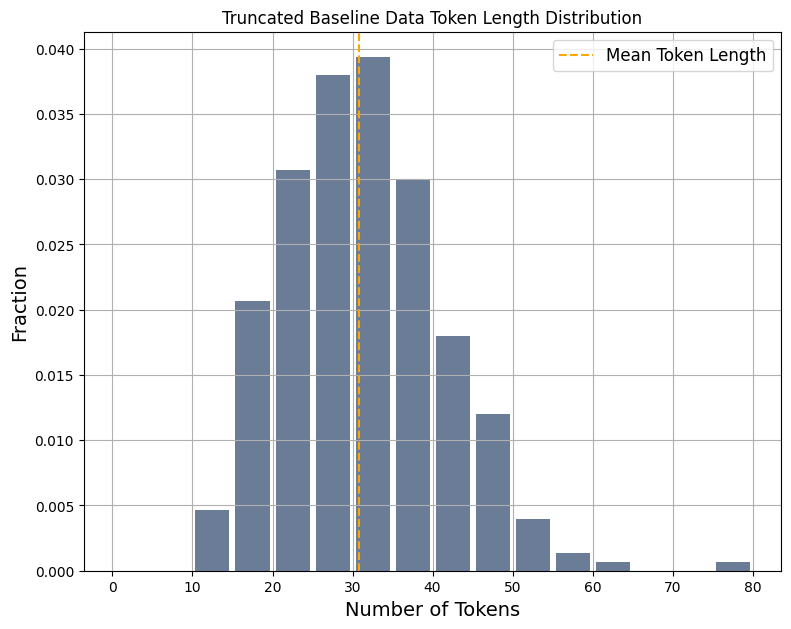

Mean Token Length of Truncated Baseline Data: 30.813333333333333


In [706]:
# Plot the token length distribution after truncation
plt.figure(figsize=(9, 7))
bin_width = 5
bins = range(0, max(truncated_baseline_token_lengths) + bin_width, bin_width)
plt.hist(truncated_baseline_token_lengths, bins=bins, color='#2c456b', alpha=0.7, rwidth=0.85, density=True)
mean_truncated_baseline_token_length = truncated_baseline_token_lengths.mean()
plt.axvline(x=mean_truncated_baseline_token_length, color='orange', linestyle='--', label='Mean Token Length')
plt.xlabel('Number of Tokens', fontsize=14)
plt.ylabel('Fraction', fontsize=14)
plt.legend(loc='upper right', fontsize=12, title_fontsize=12)
plt.grid(True)
plt.title('Truncated Baseline Data Token Length Distribution')
plt.show()

print(f'Mean Token Length of Truncated Baseline Data: {mean_truncated_baseline_token_length}')

In [707]:
baseline_volkskrant_truncated

,text,text_count,link,paywall
3,Na een kletsnatte maandag volgt een veelal wis...,1,https://www.volkskrant.nl/films/nederlands-fil...,ja
8,Was aan de lijn is een levend kunstwerk. De wa...,1,https://www.volkskrant.nl/binnenland/zo-veel-m...,ja
11,Sinds Raemon Sluiter de Oekraïense Elina Svito...,1,https://www.volkskrant.nl/nieuws-achtergrond/u...,ja
13,Was aan de lijn is een levend kunstwerk. De wa...,1,https://www.volkskrant.nl/auto-en-fiets/volksw...,ja
20,Vanaf deze zomer kan er gesurft worden in een ...,1,https://www.volkskrant.nl/economie/dnb-hoeft-6...,ja
...,...,...,...,...
281,Iedereen was enthousiast over de methode-Laure...,1,https://www.volkskrant.nl/binnenland/eieren-ro...,ja
289,De gemeente Voorne aan Zee wil dat er over de ...,1,https://www.volkskrant.nl/nieuws-achtergrond/f...,ja
290,Cees Dekker | hoogleraar biofysica Hoe is het ...,1,https://www.volkskrant.nl/sport/elina-svitolin...,ja
294,Een groep hardnekkige verslaafden heeft het to...,1,https://www.volkskrant.nl/binnenland/halsema-o...,ja


In [709]:
baseline_volkskrant_truncated.to_csv('..\\data\\baseline\\text_baseline_volkskrant.csv')
baseline_nrc_truncated.to_csv('..\\data\\baseline\\text_baseline_nrc.csv')
baseline_ad_truncated.to_csv('..\\data\\baseline\\text_baseline_ad.csv')
